In [1]:
# Import requests and BeautifulSoup libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt
import re
import urllib.request

In [2]:
# Define the URL of the website
url = "https://www.phei.co.id/Data/HPW-dan-Imbal-Hasil"

response = requests.get(url)
html_response = response.content
text_find = response.text
df_list = pd.read_html(html_response)

In [3]:
# Find Date in Website
count = 0
for i in range(70):
    try :
        a = text_find[i*1000:(i+1)*1000].find('<div id="dnn_ctr1477_GovernmentBondBenchmark_idIGSYC_tdTgl">')
        if a != -1:
            save_multiplier = i
            save_first = a
            print(save_first, save_multiplier)
    except :
        count +=1

747 36


In [4]:
date_yc = text_find[save_first+save_multiplier*1000 :100+save_first+save_multiplier*1000]
date_yc = date_yc.split(' ')[-2]
split = date_yc.find('<')
clean_date = date_yc[:split]
clean_date

'11-Desember-2023'

In [5]:
if int(clean_date.split('-')[0]) < 10:
    cleaner_date = clean_date.split('-')
    cleaner_date[0] = '0' + cleaner_date[0]
    clean_date = '-'.join(cleaner_date)
clean_date

'11-Desember-2023'

In [6]:
sub_path = f'/workspaces/NSS-Model/Scrape PHEI/{clean_date.split("-")[2]}-{clean_date.split("-")[1]}'
try:
    os.makedirs(sub_path)
    print(f"Folder {sub_path} created!")
except FileExistsError:
    print(f"Folder {sub_path} already exists")

sub_path += '/image'
try:
    os.makedirs(sub_path)
    print(f"Folder {sub_path} created!")
except FileExistsError:
    print(f"Folder {sub_path} already exists")

Folder /workspaces/NSS-Model/Scrape PHEI/2023-Desember already exists
Folder /workspaces/NSS-Model/Scrape PHEI/2023-Desember/image already exists


In [7]:
# Save image from Website
img_location_url = text_find[re.search('ChartPic', text_find).start():re.search('ChartPic', text_find).start()+200].split(' ')[0][:-1]
imgURL = "https://www.phei.co.id/"+img_location_url
urllib.request.urlretrieve(imgURL,f'/workspaces/NSS-Model/Scrape PHEI/{clean_date.split("-")[2]}-{clean_date.split("-")[1]}/image/{clean_date}.jpeg')


('/workspaces/NSS-Model/Scrape PHEI/2023-Desember/image/11-Desember-2023.jpeg',
 <http.client.HTTPMessage at 0x7f64c2c32440>)

In [8]:
def prepare_data(df, type_df):
    copy_df = df.copy()
    copy_df.drop(columns = copy_df.columns[[0, -1]], inplace = True)
    copy_df['type'] = type_df
    return copy_df

In [9]:
sbn_data = prepare_data(df_list[2], 'sbn')
sbsn_data = prepare_data(df_list[3], 'sbsn')
retail_data= prepare_data(df_list[4], 'retail')

obligation_data = pd.concat((sbn_data, 
                             sbsn_data,
                             retail_data), axis = 0).reset_index(drop = True)
obligation_data

,Series,TTM (Y),Today Yield (%),Today Price (%),Yesterday Yield (%),Yesterday Price (%),Coupon (%),type
0,FR0095,468,65911,991300,65226,994000,63750,sbn
1,FR0096,919,66345,1024700,65726,1029000,70000,sbn
2,FR0098,1452,67675,1032702,67187,1037281,71250,sbn
3,FR0097,1952,68270,1031857,67884,1036086,71250,sbn
4,PBS036,168,66568,979845,66509,979843,53750,sbsn
5,PBS003,310,66336,982455,65971,983408,60000,sbsn
6,PBS037,1227,67450,1010584,67161,1013000,68750,sbsn
7,PBS033,2353,68230,991500,68109,992884,67500,sbsn
8,ORI019,18,63794,998572,63978,998470,55700,retail
9,ORI020,85,62972,988948,62779,989000,49500,retail


In [10]:
obligation_data.iloc[:,1] /= 100
obligation_data.iloc[:,2:-1] /= 10000
obligation_data

,Series,TTM (Y),Today Yield (%),Today Price (%),Yesterday Yield (%),Yesterday Price (%),Coupon (%),type
0,FR0095,4.68,6.5911,99.1300,6.5226,99.4000,6.375,sbn
1,FR0096,9.19,6.6345,102.4700,6.5726,102.9000,7.000,sbn
2,FR0098,14.52,6.7675,103.2702,6.7187,103.7281,7.125,sbn
3,FR0097,19.52,6.8270,103.1857,6.7884,103.6086,7.125,sbn
4,PBS036,1.68,6.6568,97.9845,6.6509,97.9843,5.375,sbsn
5,PBS003,3.10,6.6336,98.2455,6.5971,98.3408,6.000,sbsn
6,PBS037,12.27,6.7450,101.0584,6.7161,101.3000,6.875,sbsn
7,PBS033,23.53,6.8230,99.1500,6.8109,99.2884,6.750,sbsn
8,ORI019,0.18,6.3794,99.8572,6.3978,99.8470,5.570,retail
9,ORI020,0.85,6.2972,98.8948,6.2779,98.9000,4.950,retail


In [11]:
obligation_data.to_excel(f'/workspaces/NSS-Model/Scrape PHEI/{clean_date.split("-")[2]}-{clean_date.split("-")[1]}/Bond-Data-{clean_date}.xlsx', 
            sheet_name=clean_date)

In [12]:
df = pd.concat((df_list[0],df_list[1]), axis = 0)[['Tenor Year', 'Today']]
df['Tenor Year'] /= 10
df['Today'] /= 1e6
df.rename(columns = {'Today': 'IBPA Yield'}, inplace = True)
df.set_index('Tenor Year', inplace=True)

In [13]:
def spot_rate(df):
    spot_data = df.values.copy()
    for j in range(2,df.shape[0]):
        minus = 0
        for k in range(1,j):
            minus -= spot_data[j]/(1+spot_data[k])**k
        spot_data[j] = ((1+df.iloc[j])/(1+minus))**(1/j)-1
    return spot_data

In [14]:
df['Spot-Rate'] = spot_rate(df)

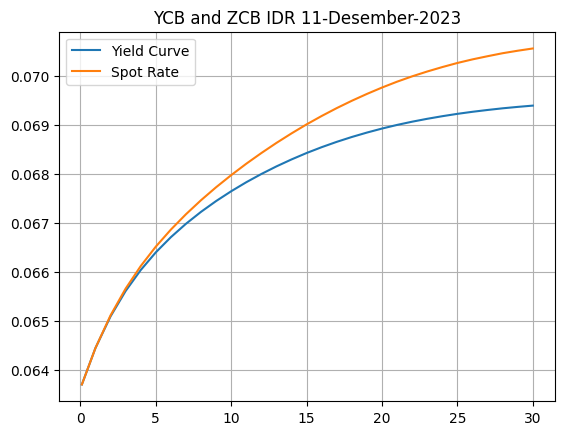

In [15]:
plt.plot(df.index, df['IBPA Yield'], label = 'Yield Curve')
plt.plot(df.index, df['Spot-Rate'], label = 'Spot Rate')
plt.legend()
plt.title(f'YCB and ZCB IDR {clean_date}')
plt.grid()
plt.show()

In [16]:
df.to_excel(f'/workspaces/NSS-Model/Scrape PHEI/{clean_date.split("-")[2]}-{clean_date.split("-")[1]}/Yield-Curve-{clean_date}.xlsx', 
            sheet_name=clean_date)